# Forecasting crime with Facebook Prophet

#### 1. Import libraries and data

In [1]:
import pandas as pd 
import numpy as np 


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

from prophet import Prophet 
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt 
%matplotlib inline

import itertools

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

import holidays

import plotly.graph_objs as go

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot
plt.style.use('fivethirtyeight')

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the data
df = pd.read_csv('lrpd-clean.csv')

#### 2. Reducing memory helps us do feature engineering faster and more efficiently

In [3]:
# Reduce memory like we did in data cleanup
def reduce_mem_usage(df, category=False):
  start_mem = df.memory_usage().sum() / 1024 **2
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

  for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
        if c_min  > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
          df[col] = df[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)
    else:
      if category:
        df[col] = df[col].astype('category')

  end_mem = df.memory_usage().sum() / 1024 ** 2
  print('Memory usage after optimizations: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
  return df

df = reduce_mem_usage(df)

Memory usage of dataframe is 10.60 MB
Memory usage after optimizations: 5.47 MB
Decreased by 48.4%


#### 3. Set correct data types

In [4]:
df["INCIDENT_DATE"] = pd.to_datetime(df["INCIDENT_DATE"])
df.dtypes

INCIDENT_NUMBER                object
INCIDENT_DATE          datetime64[ns]
LOCATION_DISTRICT             float16
OFFENSE_DESCRIPTION            object
WEAPON_TYPE                    object
ZIP                           float32
LATITUDE                      float16
LONGITUDE                     float16
WEEK_OF_MONTH                    int8
YEAR                            int16
DAY                              int8
DAY_OF_YEAR                     int16
MONTH                            int8
CRIME_TYPE                     object
RISK_TYPE                      object
RISK_TYPE_BC                     int8
dtype: object

#### 4. Prophet takes a dataframe with two columns: ds and y.
* The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.
*  The y column must be numeric, and represents the measurement we wish to forecast.

In [5]:
df = df.groupby(pd.Grouper(key='INCIDENT_DATE', freq='D')).size().reset_index(name='INCIDENT_COUNT')
df.columns = ['ds', 'y']

In [6]:
len(df)

2242

#### 5. Make a baseline model using Prophet to see how well the model does without adding regressors, holidays or hyperparameter tuning.

In [7]:

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Initialize and fit the model on the train set
m = Prophet()
m.fit(train_df)

# Make predictions for the train and test sets
future_train = m.make_future_dataframe(periods=len(train_df))
forecast_train = m.predict(future_train)

future_test = m.make_future_dataframe(periods=len(test_df))
forecast_test = m.predict(future_test)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_baseline = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_baseline)


14:14:24 - cmdstanpy - INFO - Chain [1] start processing
14:14:24 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.74044614071794
Test RMSE: 9.09809956126226


#### 6. Lets add holidays to the model to see how well it does.

In [8]:
# After zooming into the data, we see that arround christmas and 4th of july, we have an affect because of the holidays.
christmas = pd.DataFrame({'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24', '2021-12-24', '2022-12-24']),
  'lower_window': -2,
  'upper_window': 5,
})

fourth_of_july = pd.DataFrame({'holiday': 'Fourth of July',
    'ds': pd.to_datetime(['2017-07-04','2018-07-04','2019-07-04','2020-07-04', '2021-07-04', '2022-07-04']),
    'lower_window': -1,
    'upper_window': 1,
})

m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True, holidays=christmas)
m.add_country_holidays(country_name='US')
m.fit(train_df)

future_train = m.make_future_dataframe(periods=len(train_df))
forecast_train = m.predict(future_train)

future_test = m.make_future_dataframe(periods=len(test_df))
forecast_test = m.predict(future_test)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_holiday = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_holiday)


14:14:25 - cmdstanpy - INFO - Chain [1] start processing
14:14:26 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.426904337553296
Test RMSE: 9.503108288453053


## Putting it all together

* Now we can start putting everything together by hyperparameter tuning, adding holidays, and eventually adding weather data as well.

In [9]:
df = pd.read_csv('lrpd-clean.csv')
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'])
df = df.groupby(pd.Grouper(key='INCIDENT_DATE', freq='D')).size().reset_index(name='INCIDENT_COUNT')
df.columns = ['ds', 'y']
df.shape


(2242, 2)

In [10]:
# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

I commented out this cell to save time on finding the best parameters as it would take a long time to run.

If you would like to run it, uncomment it and run it. 

Make sure to comment the next cell.

In [11]:
# # Define the parameter grid
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.1],
#     'seasonality_prior_scale': [0.01, 1.0],
#     'holidays_prior_scale': [0.01, 0.1],
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'daily_seasonality': [True, False],
#     'weekly_seasonality': [True, False],
#     'yearly_seasonality': [True, False],
#     'holidays': [christmas, fourth_of_july],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []

# for params in all_params:
#     m = Prophet(**params).fit(train_df)

#     future_train = m.make_future_dataframe(periods=len(train_df))
#     forecast_train = m.predict(future_train)

#     future_test = m.make_future_dataframe(periods=len(test_df))
#     forecast_test = m.predict(future_test)

#     # Evaluate performance on the train set
#     y_true_train = train_df['y'].values
#     y_pred_train = forecast_train['yhat'].values[:len(train_df)]
#     rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

#     # Evaluate performance on the test set
#     y_true_test = test_df['y'].values
#     y_pred_test = forecast_test['yhat'].values[-len(test_df):]
#     rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

#     rmses.append(rmse_test)

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

# # Python
# best_params = all_params[np.argmin(rmses)]
# print(best_params)


In [12]:
best_params = {'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 1.0,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative',
 'daily_seasonality': True,
 'weekly_seasonality': True,
 'yearly_seasonality': True, }

#### We fit the model with the best parameters, and the holidays data.

In [13]:
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')

m.fit(train_df)

future_train = m.make_future_dataframe(periods=len(train_df))
forecast_train = m.predict(future_train)

future_test = m.make_future_dataframe(periods=len(test_df))
forecast_test = m.predict(future_test)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_tuned = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print("Test RMSE:", rmse_test_tuned)


14:14:27 - cmdstanpy - INFO - Chain [1] start processing
14:14:27 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.508450770776641
Test RMSE: 9.03544920072547


#### We add weather data from the local Little Rock airport weather station to the model

It is important to note that we will also need the weather data for the future in order to make forecasts on the future. 

We can obtain that data by using a weather data API to get the weather forecast for the horizon.

In [14]:
weather = pd.read_csv('weather.csv')
best_data = weather[weather['NAME'] == 'LITTLE ROCK AIRPORT ADAMS FIELD, AR US']
columns_to_keep = ['DATE', 'AWND', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN']
best_data = best_data[columns_to_keep]
best_data.fillna(0, inplace=True)
best_data = best_data[best_data['DATE'] < '2023-02-21']
best_data['DATE'] = pd.to_datetime(best_data['DATE'])
best_df = pd.merge(df, best_data, left_on='ds', right_on='DATE', how='inner')
best_df.drop(columns=['DATE'], inplace=True)

In [15]:
best_df.head()

,ds,y,AWND,PRCP,SNWD,SNOW,TMAX,TMIN
0,2017-01-01,54,6.93,0.01,0.0,0.0,46.0,43.0
1,2017-01-02,45,5.37,0.20,0.0,0.0,56.0,45.0
2,2017-01-03,49,7.61,0.00,0.0,0.0,57.0,40.0
3,2017-01-04,48,9.62,0.00,0.0,0.0,41.0,26.0
4,2017-01-05,39,8.50,0.00,0.0,0.0,37.0,29.0


Perform hyperparameter tuning after added regressors too. 

In [16]:
finalDf = pd.read_csv('final-lrpd-data.csv')
list2 = ['is_holiday', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'is_weekend', 'is_weekday',
       'season', 'AWND', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN']
estimator = Ridge()
selector = RFECV(estimator, step=10, cv=10)
selector = selector.fit(finalDf[list2], finalDf['y'])
to_keep = finalDf[list2].columns[selector.support_]


I commented out this cell to save time on finding the best parameters as it would take a long time to run.

If you would like to run it, uncomment it and run it. 

Make sure to comment the next cell.

In [17]:
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.1],
#     'seasonality_prior_scale': [0.01, 1.0],
#     'holidays_prior_scale': [0.01, 0.1],
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'daily_seasonality': [True, False],
#     'weekly_seasonality': [True, False],
#     'yearly_seasonality': [True, False]
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []

# for params in all_params:

#     m = Prophet(**params)
#     m.add_country_holidays(country_name='US')

#     # Add regressors to the dataframe
#     for f in to_keep:
#         df[f] = finalDf[f]
#         m.add_regressor(f)

#     train_size = int(len(df) * 0.8)
#     train_df = df[:train_size]
#     test_df = df[train_size:]

#     m.fit(train_df)

#     future_train = train_df.drop(columns=['y']).copy()
#     for f in to_keep:
#         future_train[f] = finalDf[f][:train_size]

#     forecast_train = m.predict(future_train)

#     # Evaluate performance on the train set
#     y_true_train = train_df['y'].values
#     y_pred_train = forecast_train['yhat'].values[:len(train_df)]
#     rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

#     print("Train RMSE:", rmse_train)

#     # Evaluate performance on the test set
#     future_test = test_df.drop(columns=['y']).copy()
#     for f in to_keep:
#         future_test[f] = finalDf[f][train_size:]

#     forecast_test = m.predict(future_test)

#     y_true_test = test_df['y'].values
#     y_pred_test = forecast_test['yhat'].values[-len(test_df):]
#     rmse_test_weather = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

#     rmses.append(rmse_test_weather)


# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

# # Python
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

In [18]:
best_params = {'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 0.01,
 'holidays_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative',
 'daily_seasonality': False,
 'weekly_seasonality': True,
 'yearly_seasonality': True}

Training with the best params!

In [19]:

m = Prophet(**best_params)
m.add_country_holidays(country_name='US')

# Add regressors to the dataframe
for f in to_keep:
    df[f] = finalDf[f]
    m.add_regressor(f)

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

m.fit(train_df)

future_train = train_df.drop(columns=['y']).copy()
for f in to_keep:
    future_train[f] = finalDf[f][:train_size]

forecast_train = m.predict(future_train)

# Evaluate performance on the train set
y_true_train = train_df['y'].values
y_pred_train = forecast_train['yhat'].values[:len(train_df)]
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))

print("Train RMSE:", rmse_train)

# Evaluate performance on the test set
future_test = test_df.drop(columns=['y']).copy()
for f in to_keep:
    future_test[f] = finalDf[f][train_size:]

forecast_test = m.predict(future_test)

y_true_test = test_df['y'].values
y_pred_test = forecast_test['yhat'].values[-len(test_df):]
rmse_test_weather = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
mape_test_weather = mean_absolute_percentage_error(y_true_test, y_pred_test)

print("Test RMSE:", rmse_test_weather)


14:14:29 - cmdstanpy - INFO - Chain [1] start processing
14:14:29 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 7.388912014451658
Test RMSE: 8.089463431122185


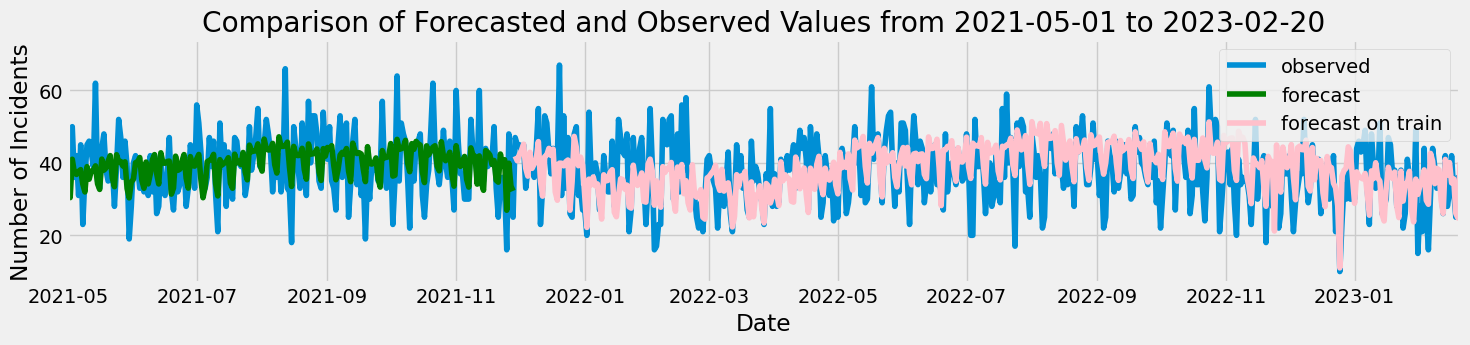

In [22]:
plt.figure(figsize=(13, 5))
plt.plot(df.ds, df.y, label='observed')


plt.plot(forecast_train['ds'], forecast_train['yhat'],
         label='forecast', color='green')
plt.plot(forecast_test['ds'], forecast_test['yhat'],
         label='forecast on train', color='pink')
plt.title('Comparison of Forecasted and Observed Values from 2021-05-01 to ' + str(forecast_test.ds.iloc[-1])[:10])
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()


plt.xlim(pd.Timestamp('2021-05-01'), pd.Timestamp(forecast_test.ds.iloc[-1]))
plt.gcf().set_size_inches(16, 3)
plt.savefig('../neural-prophet-forecast.png')
plt.show() 

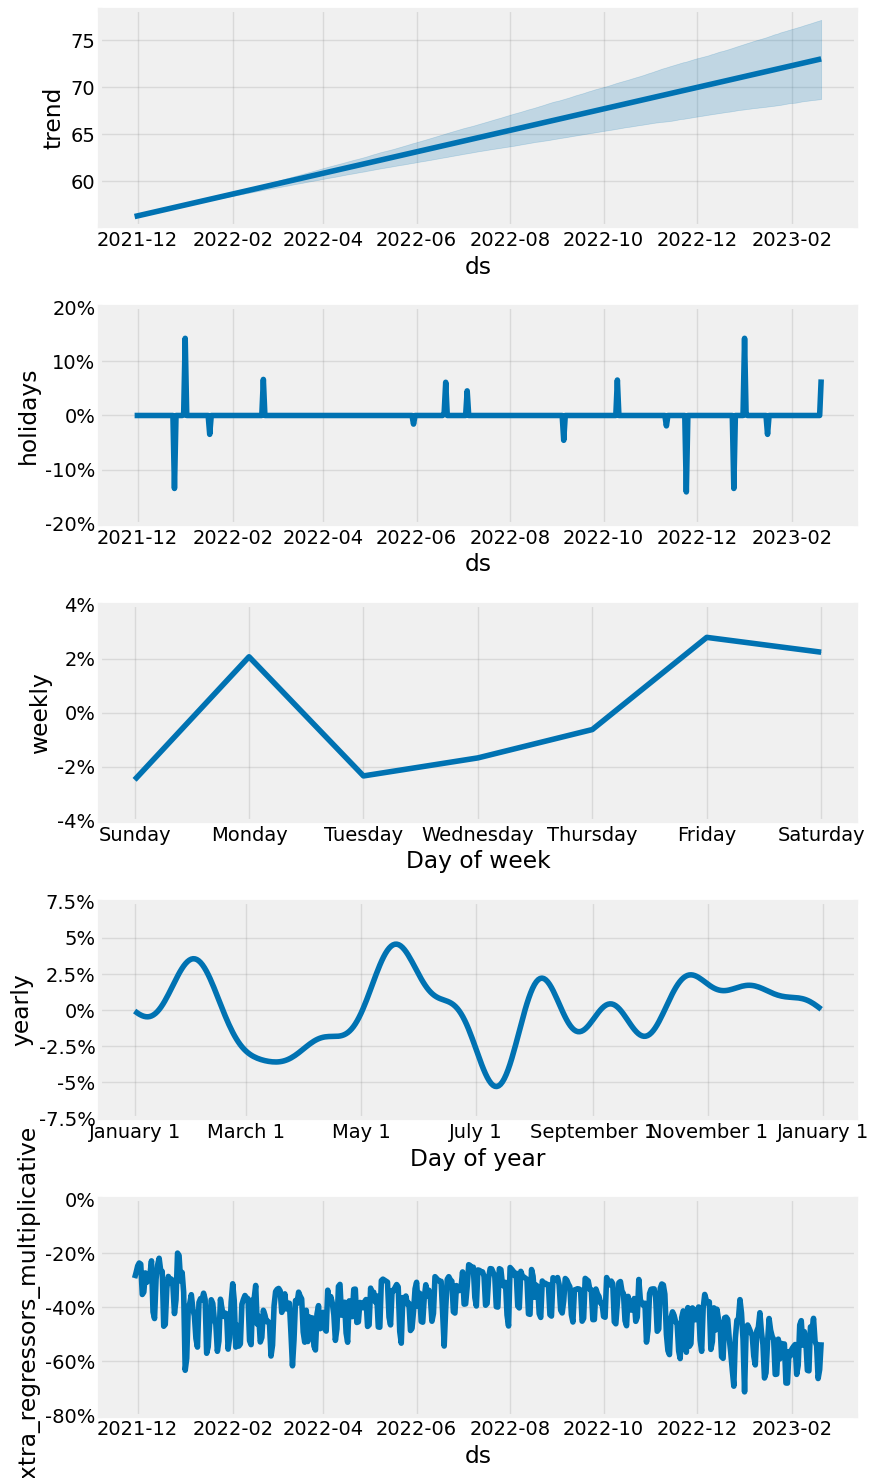

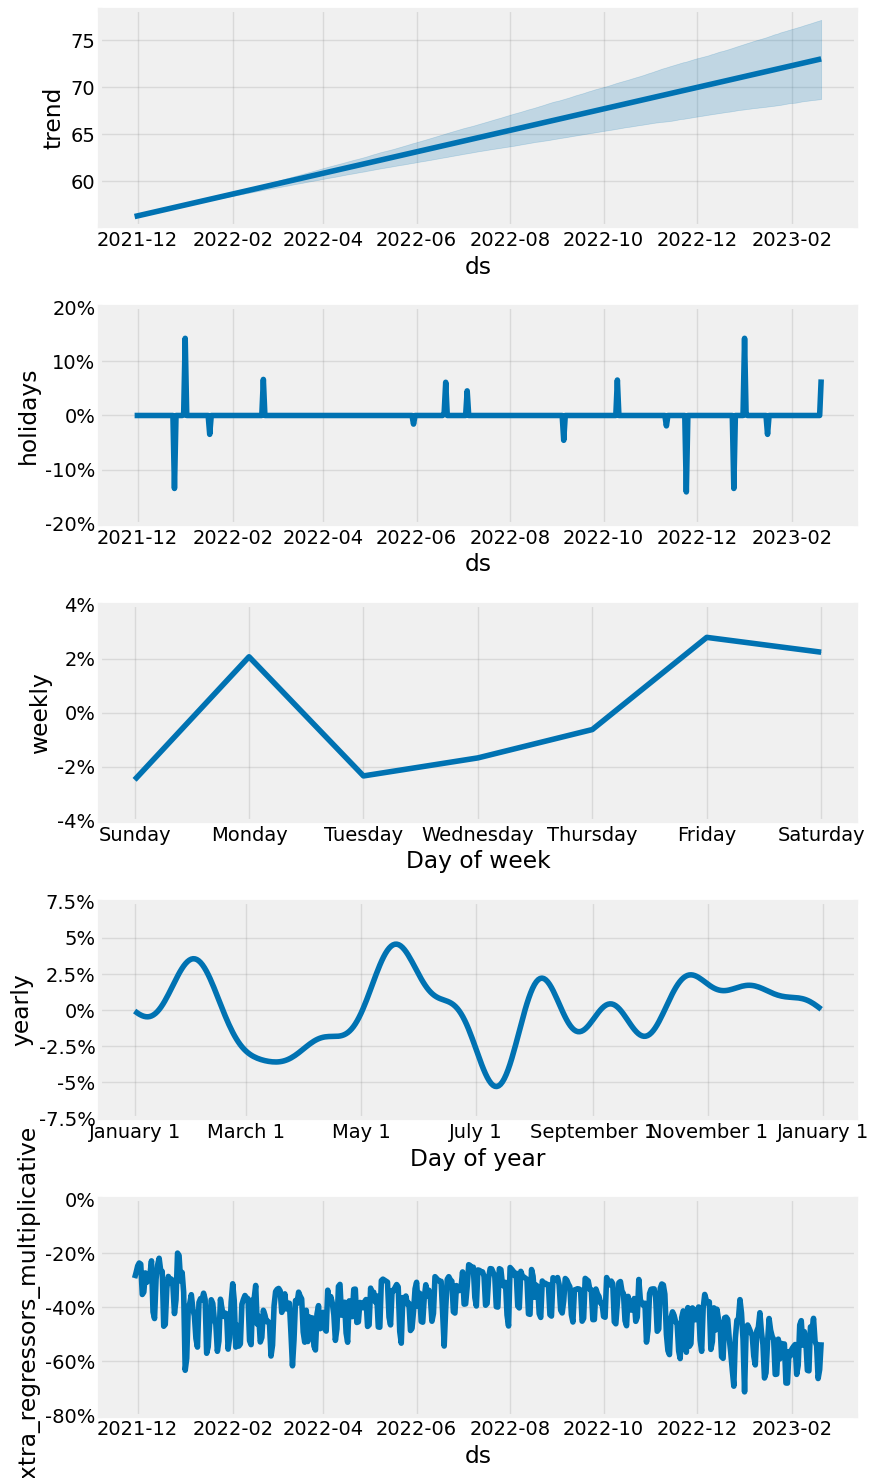

In [91]:
m.plot_components(forecast_test)

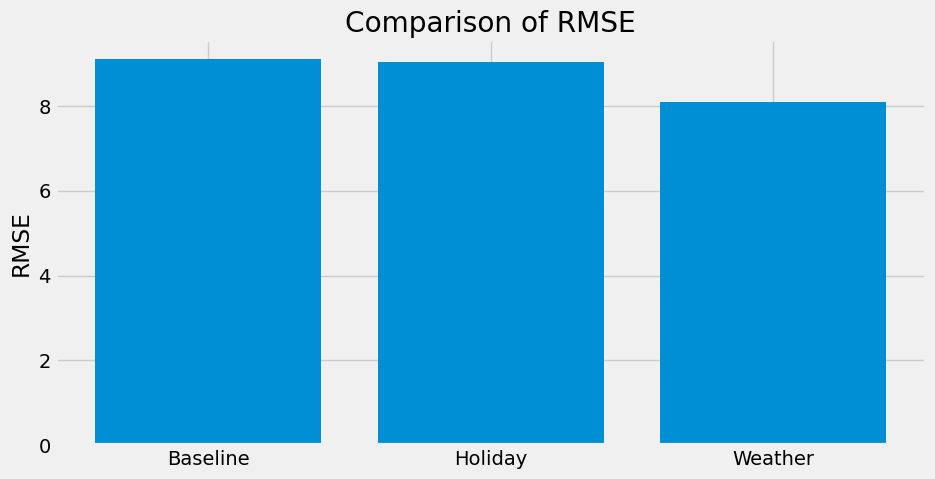

In [92]:
comparison = pd.DataFrame()
comparison['Model'] = ['Baseline', 'Holiday', 'Weather']
comparison['RMSE'] = [rmse_test_baseline, rmse_test_tuned, rmse_test_weather]
# plot the results
plt.figure(figsize=(10, 5))
plt.bar(comparison['Model'], comparison['RMSE'])
plt.title('Comparison of RMSE')
plt.ylabel('RMSE')
plt.show()